In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from PIL import Image

**Open in colab** : 
<a target="_blank" href="https://colab.research.google.com/github/toelt-llc/HSLU-WSCS_2025/blob/master/ap_notebooks/ap1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Data
You will need to download the dataset from [kaggle](https://www.kaggle.com/datasets/arnavr10880/concrete-crack-images-for-classification?resource=download).  
Once extracted, rename the downloaded folder to *concrete* and place it into the *data* folder 

In [2]:
# Collect data
negative_dir = './datasets/concrete/Negative'
positive_dir = './datasets/concrete/Positive'

In [3]:
def load_images(folder, target_size=None):
    image_arrays = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(('.jpg', '.png')):
            img = Image.open(img_path).convert('RGB') #3 channels images
            if target_size:
                img = img.resize(target_size)
            img_array = np.array(img)
            image_arrays.append(img_array)

    return np.stack(image_arrays)

In [4]:
negative_images = load_images(negative_dir, (224, 224)) # reshape to 224 for network processing
positive_images = load_images(positive_dir, (224, 224))

Quick visualization 

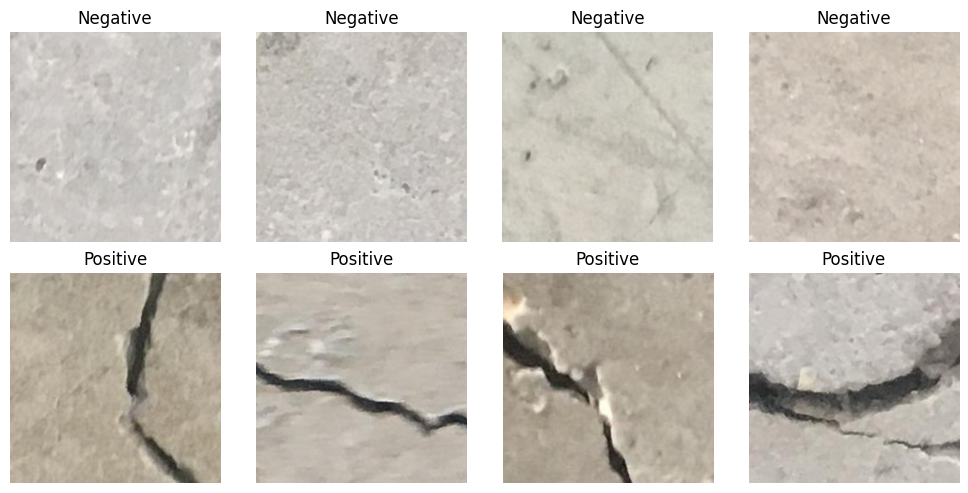

In [10]:
# Display samples of Negative and Positive Concrete Cracks
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(negative_images[i])
    plt.axis('off')
    plt.title('Negative')
    
    plt.subplot(2, 4, i + 5)
    plt.imshow(positive_images[i])
    plt.axis('off')
    plt.title('Positive')

plt.tight_layout()
plt.show()

## Preprocess the data

Before training the network, the data must be preprocessed.  
We can inspect the images in the datas, to see that the pixel values fall in the range of 0 to 255:

In [11]:
print(positive_images.min(), positive_images.max()) # min and max over all 3 channels of the 20000 images
print(negative_images.min(), negative_images.max()) 

0 255
2 255


We want to scale these values to a range of 0 to 1 before feeding them to the neural network model.  
To do so, we divide the values by 255. It's important that all the data sets are preprocessed in the same way:

In [7]:
positive_images = positive_images / 255.0
negative_images = negative_images / 255.0

Values are now scaled between 0 and 1. 

### Train / test split

In a supervised training setting, each image type is linked with a label.  
Here we create an array of labels of the size of each image type (20000), 0 for negative, 1 for positive 

In [13]:
positive_labels = np.ones(20000)
negative_labels = np.zeros(20000)

# We now have the positive+negative images and labels array
print(positive_images.shape, negative_images.shape)
print(positive_labels.shape, negative_labels.shape)

(20000, 224, 224, 3) (20000, 224, 224, 3)
(20000,) (20000,)


We merge all the images and labels together, and then separate them into a training and test set.  

In [16]:
all_images = np.vstack((positive_images, negative_images))
all_labels = np.hstack((positive_labels, negative_labels))

In [17]:
all_images.shape, all_labels.shape

((40000, 224, 224, 3), (40000,))

In [18]:
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2) # 20% of the data will be used for evaluation

We now have four NumPy arrays:
 - The train_images and train_labels arrays are the training set—the data the model uses to learn.
 - The model is tested against the test set, the test_images, and test_labels arrays.
 - The array sizes proportion depend of the test_size parameter 

## Model building
Building the neural network requires configuring the layers of the model, then compiling the model.

The basic building block of a neural network is the layer. Layers extract representations from the data fed into them.  
Most of deep learning consists of chaining together simple layers. Most layers, such as tf.keras.layers.Dense and Conv2D, have parameters that are learned during training.  

In [19]:
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

/Users/arnaud/miniconda3/envs/wscs/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model compilation
Before the model is ready for training, it needs a few more settings or *hyperparameters*. 

**Optimizer** : This is how the model is updated based on the data it sees and its loss function.  
**Lossfunction** : his measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.  
**Metrics** : Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Model training

 - Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
 - The model learns to associate images and labels.
 - We ask the model to make predictions about a test set—in this example, the test_images array.
 - Do the predictions match the labels from the test_labels array ?

In [ ]:
history = model.fit(train_images, train_labels, epochs=10)

In [ ]:
# Visualize accuracy and model loss 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Evaluation
Performance on test data split can be quickly evaluated.

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

## Prediction
On unseen image(s)

In [ ]:
def predict_image(img_path):
    img = Image.open(img_path)
    img = img.resize(img_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    return 'Positive' if prediction[0][0] > 0.5 else 'Negative'

# Example prediction (by positive crack)
print(predict_image('./datasets/concrete/Positive/00004.jpg'))

In [ ]:
# Example prediction (by negative crack)
print(predict_image('./datasets/concrete/Negative/00002.jpg'))